In [267]:
%load_ext nb_black

from __future__ import annotations

import os
from pathlib import Path

import matplotlib.pyplot as plt
import pymagicc
import scmdata
import pickle
import xarray as xr
import numpy as np

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [268]:
import pint
import openscm_units
# Have to set this before importing so the verify_units wrappers
# behave with carbon cycle units like GtC.
pint.set_application_registry(openscm_units.unit_registry)

<IPython.core.display.Javascript object>

In [269]:
UR = pint.get_application_registry()
Q = UR.Quantity
QType = pint.UnitRegistry.Quantity

<IPython.core.display.Javascript object>

In [270]:
# import parameter values 
path = (
    "/Users/gatang/Research/MAGICC CN Cycle/magicc-cn-cycle/notebooks/cali_res_txt_pkl/"
)
with open(path + "para_dict_A.pkl", "rb") as file:
    # Load the data from the Pickle file
    para_dict_A = pickle.load(file)

<IPython.core.display.Javascript object>

In [271]:
mdl_A = list(para_dict_A.keys())[:6]

<IPython.core.display.Javascript object>

In [272]:
mdl_A

['CMCC-CM2-SR5',
 'CMCC-ESM2',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'MIROC-ES2L']

<IPython.core.display.Javascript object>

In [273]:
mdl = mdl_A[4]
exp = "hist_ssp585"
mdl

'UKESM1-0-LL'

<IPython.core.display.Javascript object>

In [274]:
# import the mdl_cn_cycle input
path = "/Users/gatang/Research/MAGICC CN Cycle/magicc-cn-cycle/data/CMIP6/"+mdl+"_gl_yr_for_MAGICC_GT.nc"
ds = xr.open_dataset(path)

<IPython.core.display.Javascript object>

In [275]:
CO2_hist_ssp = xr.open_dataset("/Users/gatang/Research/MAGICC CN Cycle/magicc-cn-cycle/data/CMIP6/CO2_hist_ssp_for_MAGICC_GT.nc")

<IPython.core.display.Javascript object>

In [276]:
para_cn = para_dict_A[mdl]
para_cn["n_switch"] = Q(1, "1")
para_cn["t0"] = Q(ds.sel(exp=exp)["time"].data[0].year, "yr")
para_cn["CplsP0"] = Q(ds.sel(exp=exp)["cVeg"].data[0], "GtC")

para_cn["CplsL0"] = Q(ds.sel(exp=exp)["cLitter"].data[0], "GtC") if "UKESM" not in mdl else Q(0, "GtC")
para_cn["CplsS0"] = Q(ds.sel(exp=exp)["cSoil"].data[0], "GtC")
para_cn["NplsP0"] = Q(ds.sel(exp=exp)["nVeg"].data[0], "GtN")
para_cn["NplsL0"] = Q(ds.sel(exp=exp)["nLitter"].data[0], "GtN") if "UKESM" not in mdl else Q(0, "GtN")
para_cn["NplsS0"] = Q(ds.sel(exp=exp)["nSoil"].data[0], "GtN")
para_cn["NplsM0"] = Q(ds.sel(exp=exp)["nMineral"].data[0], "GtN")

<IPython.core.display.Javascript object>

In [277]:
land_cn_para = {}
for i in list(para_cn.keys()):
    j = i.lower()
    land_cn_para[j] = para_cn[i].m

land_cn_para["step_size"] = 0.5
land_cn_para

{'co2ref': 284.3169860839844,
 'co2b': 31,
 's_dt2npp': -0.22263960637345248,
 's_dt2npp_sig': 0.24876508020516208,
 'method_eff_dt2npp': 0.8437278436755538,
 's_co2_log': 0.11268086177157863,
 's_co2_sig': 0.003987759047925173,
 'method_eff_co2': 0.994867090626594,
 'cflxnpp0': 69.9491837983166,
 'nflxpumax': 2.6659131588548064,
 'cflxnppref': -118.9678587973138,
 's_dt2pu': -0.048158768602243746,
 'eff_cn2npp0': 1.230947067097159,
 's_pu2npp': -0.8374784635680705,
 's_ad2npp': 1.6932514008976498,
 'frclurgr': 0.999681783909657,
 'time_rgr': 50.047163140767836,
 'cflxlpr0': 4.163130325706606,
 's_dt2lpr': -0.19264145490325066,
 'frcnpp2p': 0.487647734833344,
 'frcnpp2l': 0.0,
 'frclp2l': 0.0,
 'frcld2s': 0.0,
 'frclu2p': 0.9391913430996246,
 'frclu2l': 0.0,
 's_dt2lp_c': 0.03994822211987838,
 's_pu2lp_c': -1.7775638314439437,
 's_ad2lp_c': 6.884423451939254,
 's_dt2ld_c': 0.0,
 's_pu2ld_c': 0.0,
 's_ad2ld_c': 0.0,
 's_dt2sr_c': 0.06380036506072967,
 's_pu2sr_c': -1.3632151438759754,
 

<IPython.core.display.Javascript object>

In [278]:
saved_path = "/Users/gatang/MAGICC/magicc/run/"

<IPython.core.display.Javascript object>

In [279]:
for i, j in zip(["dT_s", "CO2_s", "CflxLU_s", "NflxAD_s", "NflxBNF_s", "NflxFT_s", "NflxLU_s"],["tas", "co2", "fAnthLucFireBalanced", "fNdep", "fBNF", "fNfert", "fNAnthLucFire"]):
    if "dT" in i:
        value_unit = "k"
    elif "CO2" in i:
        value_unit = "ppm"
    elif "Cflx" in i:
        value_unit = "GtC/yr"
    elif "Nflx" in i:
        value_unit = "GtN/yr"
    timeaxis_unit = "yr"
    
    if j != "co2":
        da = ds[j].sel(exp=exp)
        value_array = da.data
        value_array = value_array[~np.isnan(value_array)]
        array_size = len(value_array)
        value_last_bound = value_array[-1]
        timeaxis_array = da["time"].dt.year.data[:array_size]
        timeaxis_last_bound = timeaxis_array[-1] + 1
    else:
        da = CO2_hist_ssp[exp]
        value_array = da.data
        value_array = value_array[:array_size]
        array_size = len(value_array)
        value_last_bound = value_array[-1]
        timeaxis_array = da["time"].data[:array_size]
        timeaxis_last_bound = timeaxis_array[-1] + 1
        
    name = i.lower()
    with open(saved_path + 'land_cn_input_' + name +'.txt', 'w') as file:
        # Write the array name and values
        file.write('&nml_land_cn_input_timeseries'+ "\n")
        file.write('  name = ' + f'"{name}"' + ",\n")
        file.write('  array_size = ' + str(array_size) +",\n")
        file.write('  value_array = ' + ', '.join(str(k) for k in value_array) + ",\n")
        file.write('  value_last_bound = ' + str(value_last_bound) +",\n")
        file.write('  value_unit = ' + f'"{value_unit}"' + ",\n")
        file.write('  timeaxis_array = ' + ', '.join(str(k) for k in timeaxis_array) + ",\n")
        file.write('  timeaxis_last_bound = ' + str(timeaxis_last_bound) +",\n")
        file.write('  timeaxis_unit = ' + f'"{timeaxis_unit}"' +",\n")
        file.write('/')
        file.write('\n\n')

<IPython.core.display.Javascript object>

In [280]:
# Gang to change path if needed
ROOT_DIR_MAGICC_REPO = "/Users/gatang/MAGICC/magicc"
os.environ["MAGICC_EXECUTABLE_7"] = str(ROOT_DIR_MAGICC_REPO + "/bin/magicc")

<IPython.core.display.Javascript object>

In [281]:
ssp = "ssp585"
scenario_filename = f"{ssp.upper()}_EMMS.SCEN7"
scenario = pymagicc.MAGICCData(
    str(ROOT_DIR_MAGICC_REPO+"/run/" + scenario_filename)
)
scenario["scenario"] = "ssp585"

<IPython.core.display.Javascript object>

In [282]:
# # Generally, don't use this
# with pymagicc.MAGICC7(root_dir=ROOT_DIR_MAGICC_REPO) as magicc:
with pymagicc.MAGICC7() as magicc:
    res_l = []
    for n_switch in [0, 1]:
        land_cn_para["n_switch"] = n_switch
        res_run = magicc.run(
            co2_switchfromconc2emis_year=2015,
            scenario=scenario,
            out_dynamic_vars=[
                "DAT_SURFACE_TEMP",
                "DAT_CO2_CONC",
                "DAT_CO2_LAND_POOL",
                "DAT_CO2_NETATMOSLANDCO2FLUX",
                "DAT_CO2_CURRENT_NPP",
                "DAT_CO2_TOTALRESPIRATION",
                "DAT_CO2_PLANT_POOL",
                "DAT_CO2_DETRITUS_POOL",
                "DAT_CO2_SOIL_POOL"
            ],
            startyear=1850,
            endyear=2100,
            land_cn_parameters=land_cn_para,
        )
            # TOOD: add variable handling
            # TODO: add argument passing

        # res_run["cplsp0"] = cplsp0
        res_run["n_switch"] = n_switch

        res_l.append(res_run)
        # breakpoint()
res = scmdata.run_append(res_l)

/Users/gatang/Research/pymagicc/pymagicc/pymagicc/core.py:444: UserWarning: magicc logged a ERROR message. Check the 'stderr' key of the result's `metadata` attribute.
  warnings.warn(
/Users/gatang/Research/pymagicc/pymagicc/pymagicc/core.py:444: UserWarning: magicc logged a ERROR message. Check the 'stderr' key of the result's `metadata` attribute.
  warnings.warn(


<IPython.core.display.Javascript object>

In [283]:
n_switch = set(res.filter(region="World")["n_switch"])

<IPython.core.display.Javascript object>

In [284]:
year = [i.year for i in list(res["time"].values)]

<IPython.core.display.Javascript object>

In [285]:
co2 = res.filter(region="World", variable='Atmospheric Concentrations|CO2')
cpls_land = res.filter(region="World", variable='CO2_LAND_POOL')
cflx_netland = res.filter(region="World", variable='CO2_NETATMOSLANDCO2FLUX')
dt = res.filter(region="World", variable='Surface Temperature')

<IPython.core.display.Javascript object>

In [286]:
npp = res.filter(region="World", variable='CO2_CURRENT_NPP')
rh = res.filter(region="World", variable='CO2_TOTALRESPIRATION')

<IPython.core.display.Javascript object>

In [287]:
cplsp = res.filter(region="World", variable='CO2_PLANT_POOL')
cplsl = res.filter(region="World", variable='CO2_DETRITUS_POOL')
cplss = res.filter(region="World", variable='CO2_SOIL_POOL')

<IPython.core.display.Javascript object>

In [288]:
var4plot= [dt, co2, cpls_land, cflx_netland, npp, rh]
label_list = ["temperature", "CO2", "CplsLand", "CflxNetLand", "npp", "rh"]

<IPython.core.display.Javascript object>

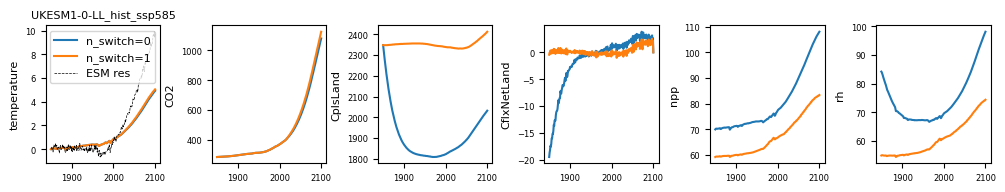

<IPython.core.display.Javascript object>

In [289]:
fig, axs = plt.subplots(1, 6, figsize=(24/2.54, 3.5/2.54))

for var, label, ax in zip(var4plot, label_list, axs):
    for i in n_switch:
        ax.plot(year, var.filter(n_switch=i).values[0])
    ax.set_ylabel(label, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)  # Major ticks
    ax.tick_params(axis='both', which='minor', labelsize=6)  # Minor ticks

axs[0].plot(year,ds["tas"].sel(exp=exp).data - ds["tas"].sel(exp=exp).data[0], "--", linewidth=0.5, color="black")
axs[0].legend(["n_switch=0", "n_switch=1", "ESM res"],fontsize=8)
axs[0].set_title(mdl+"_"+exp, fontsize=8)


plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.45, hspace=0)

In [290]:
var4plot= [cplsp, cplsl, cplss, npp, rh]
label_list = ["cplsp", "cplsl", "cplss"]

<IPython.core.display.Javascript object>

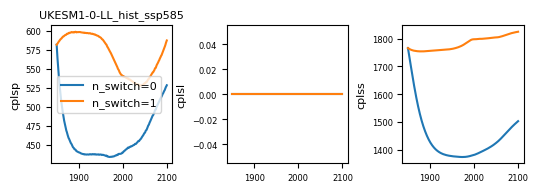

<IPython.core.display.Javascript object>

In [291]:
fig, axs = plt.subplots(1, 3, figsize=(12/2.54, 3.5/2.54))

for var, label, ax in zip(var4plot, label_list, axs):
    for i in n_switch:
        ax.plot(year, var.filter(n_switch=i).values[0])
    ax.set_ylabel(label, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)  # Major ticks
    ax.tick_params(axis='both', which='minor', labelsize=6)  # Minor ticks

axs[0].legend(["n_switch=0", "n_switch=1"],fontsize=8)
axs[0].set_title(mdl+"_"+exp, fontsize=8)


plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.45, hspace=0)

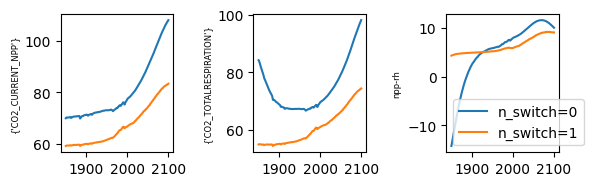

<IPython.core.display.Javascript object>

In [292]:
fig, axs = plt.subplots(1, 3, figsize=(15/2.54, 5/2.54))

for i in n_switch:
    axs[0].plot(year, npp.filter(n_switch=i).values[0])
    axs[1].plot(year,rh.filter(n_switch=i).values[0])
    axs[2].plot(year,npp.filter(n_switch=i).values[0]-rh.filter(n_switch=i).values[0])
    
    axs[0].set_ylabel(set(npp["variable"]), fontsize=6)
    axs[1].set_ylabel(set(rh["variable"]), fontsize=6)
    axs[2].set_ylabel("npp-rh", fontsize=6)

axs[-1].legend(["n_switch=0", "n_switch=1"])

plt.tight_layout()